In [1]:
# =========================================
# 0) Instalar librerías
# =========================================
!pip install lightgbm --quiet
!pip install pandas --quiet

In [2]:
# =========================================
# 1) Importar librerías
# =========================================
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# =========================================
# 2) Cargar datos 2023 y 2024
# (ajusta el nombre de archivo si son .csv)
# =========================================
df1 = pd.read_csv("2023.csv")
df2 = pd.read_csv("2024.csv")

df = pd.concat([df1, df2], ignore_index=True).copy()

In [39]:
df.head()


,Date,Source,Site ID,POC,CO,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,AQS Parameter Description,Method Code,CBSA Code,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude
0,2023-01-01,AQS,360050133,1,0.4,ppm,5,PFIZER LAB SITE,19,79.0,...,Carbon monoxide,593,35620,"New York-Newark-Jersey City, NY-NJ-PA",36,New York,5,Bronx,40.8679,-73.87809
1,2023-01-02,AQS,360050133,1,0.4,ppm,5,PFIZER LAB SITE,24,100.0,...,Carbon monoxide,593,35620,"New York-Newark-Jersey City, NY-NJ-PA",36,New York,5,Bronx,40.8679,-73.87809
2,2023-01-03,AQS,360050133,1,0.8,ppm,9,PFIZER LAB SITE,18,75.0,...,Carbon monoxide,593,35620,"New York-Newark-Jersey City, NY-NJ-PA",36,New York,5,Bronx,40.8679,-73.87809
3,2023-01-04,AQS,360050133,1,0.8,ppm,9,PFIZER LAB SITE,24,100.0,...,Carbon monoxide,593,35620,"New York-Newark-Jersey City, NY-NJ-PA",36,New York,5,Bronx,40.8679,-73.87809
4,2023-01-05,AQS,360050133,1,0.3,ppm,3,PFIZER LAB SITE,24,100.0,...,Carbon monoxide,593,35620,"New York-Newark-Jersey City, NY-NJ-PA",36,New York,5,Bronx,40.8679,-73.87809


In [4]:
# =========================================
# 3) Normalizar nombres de columnas
# =========================================
df.columns = [c.strip() for c in df.columns]

In [5]:
# =========================================
# 4) Asegurar formato de fecha
# =========================================
df['Date'] = pd.to_datetime(df['Date'], errors="coerce")

In [6]:
# =========================================
# 5) Renombrar columna objetivo a 'CO'
# =========================================
target_cols = [c for c in df.columns if 'Daily Max' in c and 'CO' in c]
if len(target_cols) == 0:
    raise ValueError("No encontré la columna objetivo (Daily Max CO).")
df = df.rename(columns={target_cols[0]: 'CO'})

In [7]:
# =========================================
# 6) Si no hay Site ID, crear uno único
# =========================================
if 'Site ID' not in df.columns:
    df['Site ID'] = 'ALL'
else:
    df['Site ID'] = df['Site ID'].astype(str).str.strip()

In [8]:
# =========================================
# 7) Agrupar por mes (media de CO en 30 días)
# =========================================
df_monthly = (
    df.groupby(["Site ID", pd.Grouper(key="Date", freq="M")])["CO"]
    .mean()
    .reset_index()
    .sort_values(["Site ID", "Date"])
)

/tmp/ipython-input-1612590242.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(["Site ID", pd.Grouper(key="Date", freq="M")])["CO"]


In [9]:
# =========================================
# 8) Crear variables de fecha y lags
# =========================================
def create_monthly_features(df):
    df = df.copy()
    df["year"] = df["Date"].dt.year
    df["month"] = df["Date"].dt.month

    lag_list = [1, 2, 3, 6]  # no ponemos 12 porque solo hay 24 meses
    for lag in lag_list:
        df[f"lag_{lag}"] = df.groupby("Site ID")["CO"].shift(lag)

    return df

df_monthly = create_monthly_features(df_monthly)

In [10]:
# =========================================
# 9) Drop NAs (por los lags)
# =========================================
df_monthly = df_monthly.dropna(subset=["lag_1"]).reset_index(drop=True)

In [11]:
# =========================================
# 10) Separar train (2023) y valid/test (2024)
# =========================================
train = df_monthly[df_monthly["year"] == 2023]
valid = df_monthly[df_monthly["year"] == 2024]

feature_cols = [c for c in df_monthly.columns if c not in ["CO", "Date"]]

X_train, y_train = train[feature_cols], train["CO"]
X_valid, y_valid = valid[feature_cols], valid["CO"]

In [18]:
print("Columnas de entrenamiento:", X_train.columns.tolist())
print(X_train.head())


Columnas de entrenamiento: ['Site ID', 'year', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_6']
     Site ID  year  month     lag_1     lag_2     lag_3  lag_6
0  360050133  2023      2  0.380645       NaN       NaN    NaN
1  360050133  2023      3  0.435714  0.380645       NaN    NaN
2  360050133  2023      4  0.332258  0.435714  0.380645    NaN
3  360050133  2023      5  0.290000  0.332258  0.435714    NaN
4  360050133  2023      6  0.287097  0.290000  0.332258    NaN


In [20]:
# ==========================================
# PASO 11 - ENTRENAMIENTO DEL MODELO
# ==========================================

from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# --- Copias para evitar warnings ---
X_train = X_train.copy()
X_valid = X_valid.copy()

# --- 11.1 Detectar columnas lag ---
lag_cols = [c for c in X_train.columns if c.startswith("lag_")]
print("Columnas de lag detectadas:", lag_cols)

# --- 11.2 Rellenar NaN en TRAIN ---
for lag in lag_cols:
    X_train[lag] = X_train.groupby("Site ID")[lag].transform(lambda s: s.fillna(s.mean()))
    X_train[lag] = X_train[lag].fillna(X_train[lag].mean())

# --- 11.3 Rellenar NaN en VALID ---
train_group_means = {lag: X_train.groupby("Site ID")[lag].mean().to_dict() for lag in lag_cols}
global_means = {lag: X_train[lag].mean() for lag in lag_cols}

def fill_valid_row(row):
    for lag in lag_cols:
        if pd.isna(row[lag]):
            row[lag] = train_group_means[lag].get(row["Site ID"], global_means[lag])
    return row

X_valid = X_valid.apply(fill_valid_row, axis=1)

# --- 11.4 Variable de tendencia temporal (t) ---
min_year = min(X_train['year'].min(), X_valid['year'].min())
for D in (X_train, X_valid):
    D['t'] = (D['year'] - min_year) * 12 + D['month']

if 't' not in feature_cols:
    feature_cols = feature_cols + ['t']

# --- 11.5 Convertir Site ID a categoría ---
X_train['Site ID'] = X_train['Site ID'].astype('category')
X_valid['Site ID'] = X_valid['Site ID'].astype('category')

# --- 11.6 Verificar shapes ---
print("Shape X_train:", X_train.shape, " Shape X_valid:", X_valid.shape)
print(X_train.head())

# --- 11.7 Definir modelo ---
model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

# --- 11.8 Entrenar modelo con early stopping ---
model.fit(
    X_train[feature_cols], y_train,
    eval_set=[(X_valid[feature_cols], y_valid)],
    eval_metric="rmse",
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
)

Columnas de lag detectadas: ['lag_1', 'lag_2', 'lag_3', 'lag_6']
Shape X_train: (107, 8)  Shape X_valid: (118, 8)
     Site ID  year  month     lag_1     lag_2     lag_3     lag_6  t
0  360050133  2023      2  0.380645  0.358227  0.350002  0.357063  2
1  360050133  2023      3  0.435714  0.380645  0.350002  0.357063  3
2  360050133  2023      4  0.332258  0.435714  0.380645  0.357063  4
3  360050133  2023      5  0.290000  0.332258  0.435714  0.357063  5
4  360050133  2023      6  0.287097  0.290000  0.332258  0.357063  6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 107, number of used features: 7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start tra

/tmp/ipython-input-643911044.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_train[lag] = X_train.groupby("Site ID")[lag].transform(lambda s: s.fillna(s.mean()))
/tmp/ipython-input-643911044.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_group_means = {lag: X_train.groupby("Site ID")[lag].mean().to_dict() for lag in lag_cols}


LGBMRegressor(learning_rate=0.05, n_estimators=2000, objective='regression',
              random_state=42)

In [21]:
# --- 11.9 Validación ---
pred_valid = model.predict(X_valid[feature_cols])
rmse = np.sqrt(mean_squared_error(y_valid, pred_valid))
r2 = r2_score(y_valid, pred_valid)

print(f"RMSE valid: {rmse:.6f}")
print(f"R2 valid: {r2:.6f}")

RMSE valid: 0.042109
R2 valid: 0.693788


In [22]:
# 12) Predicciones en el set de validación
y_pred = model.predict(X_valid)

# Guardamos resultados comparativos
df_valid_results = valid[["Site ID", "Date", "CO"]].copy()
df_valid_results["Pred_CO"] = y_pred

print(df_valid_results.head())


      Site ID       Date        CO   Pred_CO
11  360050133 2024-01-31  0.345161  0.401889
12  360050133 2024-02-29  0.389655  0.307154
13  360050133 2024-03-31  0.293548  0.352066
14  360050133 2024-04-30  0.313333  0.318386
15  360050133 2024-05-31  0.280645  0.329852


In [24]:
# 13) Predicciones futuras mes a mes para cada sitio
future_dates = pd.date_range("2025-01-01", "2026-01-31", freq="ME")  # usar "ME" en lugar de "M"

future_data = []
for site in df_monthly["Site ID"].unique():   # <-- aquí usamos df_monthly
    for d in future_dates:
        future_data.append({"Site ID": site, "Date": d})

df_future = pd.DataFrame(future_data)

# Extraer variables temporales
df_future["year"] = df_future["Date"].dt.year
df_future["month"] = df_future["Date"].dt.month

# Inicializar columnas de lags con NaN
for lag in ["lag_1", "lag_2", "lag_3", "lag_6"]:
    df_future[lag] = np.nan

In [31]:
# =========================================
# 14) Predicciones a futuro (2025–2026)
# =========================================

# Crear índice temporal "t" (si no existe)
if "t" not in df_monthly.columns:
    df_monthly = df_monthly.sort_values(["Site ID", "Date"]).reset_index(drop=True)
    df_monthly["t"] = df_monthly.groupby("Site ID").cumcount()

# Generar fechas futuras (enero 2025 – enero 2026)
future_dates = pd.date_range("2025-01-01", "2026-01-31", freq="ME")

# Copia de predicciones iniciales
future_preds = df_monthly[["Site ID", "Date", "CO", "t"]].copy()

# Iteramos para cada fecha futura
for d in future_dates:
    for site in df_monthly["Site ID"].unique():
        # último registro de ese site
        last_row = future_preds[future_preds["Site ID"] == site].iloc[-1]

        # construir fila futura
        row = {
            "Site ID": site,
            "Date": d,
            "year": d.year,
            "month": d.month,
            "lag_1": last_row["CO"],
            "lag_2": last_row.get("lag_1", last_row["CO"]),
            "lag_3": last_row.get("lag_2", last_row["CO"]),
            "lag_6": last_row.get("lag_3", last_row["CO"]),
            "t": last_row["t"] + 1,
        }

        # convertir a DataFrame
        X_future = pd.DataFrame([row])
        X_future["Site ID"] = X_future["Site ID"].astype("category")

        # predecir
        pred = model.predict(X_future[["Site ID","year","month","lag_1","lag_2","lag_3","lag_6","t"]])[0]

        # guardar predicción
        row["CO"] = pred
        future_preds = pd.concat([future_preds, pd.DataFrame([row])], ignore_index=True)

# Mostrar últimas predicciones
print(future_preds.tail(12))

       Site ID       Date        CO   t    year  month     lag_1     lag_2  \
343  361010003 2025-12-31  0.199608  34  2025.0   12.0  0.199608  0.199608   
344  361030044 2025-12-31  0.199608  33  2025.0   12.0  0.199608  0.199608   
345  360050133 2026-01-31  0.404375  35  2026.0    1.0  0.449437  0.449437   
346  360290005 2026-01-31  0.203972  35  2026.0    1.0  0.199608  0.199608   
347  360290023 2026-01-31  0.230371  35  2026.0    1.0  0.206104  0.224157   
348  360550015 2026-01-31  0.230371  33  2026.0    1.0  0.206104  0.224157   
349  360551007 2026-01-31  0.203972  35  2026.0    1.0  0.199608  0.199608   
350  360610135 2026-01-31  0.354634  35  2026.0    1.0  0.365231  0.354148   
351  360810124 2026-01-31  0.314571  35  2026.0    1.0  0.342196  0.347222   
352  360810125 2026-01-31  0.354634  33  2026.0    1.0  0.361654  0.353342   
353  361010003 2026-01-31  0.203972  35  2026.0    1.0  0.199608  0.199608   
354  361030044 2026-01-31  0.203972  34  2026.0    1.0  0.199608

In [33]:
# =========================================
# Comparar predicciones vs datos reales 2025
# =========================================

# 1) Cargar la data real 2025 (ajusta el nombre del archivo)
df_real_2025 = pd.read_csv("2025.csv")

# 2) Asegurar que las columnas coincidan en formato
df_real_2025["Date"] = pd.to_datetime(df_real_2025["Date"])
df_real_2025["Site ID"] = df_real_2025["Site ID"].astype(str)

# 3) Filtrar predicciones 2025
pred_2025 = future_preds[
    (future_preds["Date"].dt.year == 2025)
].copy()
pred_2025["Site ID"] = pred_2025["Site ID"].astype(str)

In [36]:
# --- 1) Preprocesar la data real 2025 ---
df_real_2025_proc = (
    df_real_2025[["Site ID", "Date", "Daily Max 8-hour CO Concentration"]]
    .rename(columns={"Daily Max 8-hour CO Concentration": "Real_CO"})
)

# Convertir fechas
df_real_2025_proc["Date"] = pd.to_datetime(df_real_2025_proc["Date"])

# Agregar a nivel mensual (promedio de días del mes por cada Site ID)
df_real_2025_monthly = (
    df_real_2025_proc.groupby(
        [df_real_2025_proc["Site ID"], df_real_2025_proc["Date"].dt.to_period("M")]
    )["Real_CO"].mean().reset_index()
)

# Pasar Period -> Timestamp (último día del mes)
df_real_2025_monthly["Date"] = df_real_2025_monthly["Date"].dt.to_timestamp("M")

# --- 2) Comparar con predicciones ---
df_comparativo = pd.merge(
    pred_2025[["Site ID", "Date", "CO"]].rename(columns={"CO": "Pred_CO"}),
    df_real_2025_monthly,
    on=["Site ID", "Date"],
    how="inner"
)

In [37]:
print(df_comparativo.head(15))

      Site ID       Date   Pred_CO   Real_CO
0   360050133 2025-01-31  0.377112  0.306667
1   360290005 2025-01-31  0.218134  0.219355
2   360290023 2025-01-31  0.269255  0.216129
3   360550015 2025-01-31  0.271104  0.293548
4   360551007 2025-01-31  0.210395  0.216129
5   360610135 2025-01-31  0.284964  0.358065
6   360810124 2025-01-31  0.277603  0.282353
7   361010003 2025-01-31  0.203972  0.145161
8   361030044 2025-01-31  0.203972  0.196774
9   360050133 2025-02-28  0.358047  0.314286
10  360290005 2025-02-28  0.217089  0.253571
11  360290023 2025-02-28  0.231251  0.266667
12  360550015 2025-02-28  0.231251  0.321429
13  360551007 2025-02-28  0.208900  0.250000
14  360610135 2025-02-28  0.272988  0.396429


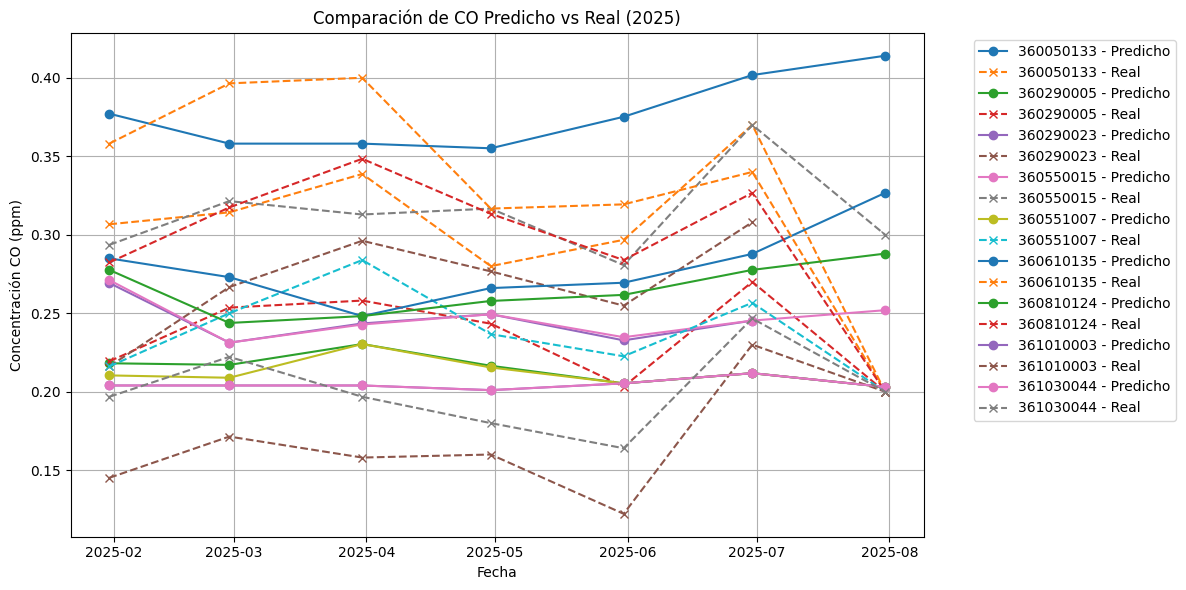

In [38]:
import matplotlib.pyplot as plt

# Asegurar que la fecha sea tipo datetime
df_comparativo["Date"] = pd.to_datetime(df_comparativo["Date"])

# Graficar Pred vs Real por estación
sites = df_comparativo["Site ID"].unique()

plt.figure(figsize=(12, 6))

for site in sites:
    data_site = df_comparativo[df_comparativo["Site ID"] == site]
    plt.plot(data_site["Date"], data_site["Pred_CO"], marker="o", label=f"{site} - Predicho")
    plt.plot(data_site["Date"], data_site["Real_CO"], marker="x", linestyle="--", label=f"{site} - Real")

plt.title("Comparación de CO Predicho vs Real (2025)")
plt.xlabel("Fecha")
plt.ylabel("Concentración CO (ppm)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()
